In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import torch
from sklearn.covariance import LedoitWolf
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

In [79]:
bs = 64
trainSize = 5000
testSize = 300

In [80]:
def get_data():
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),    
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testIn = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    OOD = datasets.SVHN(root = './data', split='test', transform = transform, download = True)
    
    print(len(data), len(testIn), len(OOD))

    data, _ = torch.utils.data.random_split(data, [trainSize, len(data)-trainSize])
    testIn, _ = torch.utils.data.random_split(testIn, [testSize, len(testIn)-testSize])
    OOD, _ = torch.utils.data.random_split(OOD, [testSize, len(OOD)-testSize])
    print(len(data), len(testIn), len(OOD))
    
    return data, testIn, OOD

In [81]:
@torch.no_grad()
def get_latent_vectors(model, train_loader, device):
    model.eval()

    latent_vectors = {}
    for cnt, x in enumerate(train_loader):
        x = x[0].to(device)

        features = model(x)
        for i in range(len(features)):
            if cnt == 0:
                latent_vectors[str(i)] = []    

            latent_vectors[str(i)].append(features[i].mean(dim=(2,3)))

    # Concatenate all vectors
    for i in range(len(features)):
        latent_vectors[str(i)] = torch.cat(latent_vectors[str(i)]).cpu().numpy()
    
    return latent_vectors

In [82]:
# Adapted from https://github.com/ORippler/gaussian-ad-mvtec
class ResNet_features(nn.Module):
    def __init__(
        self,
        resnet: nn.Module,
    ):
        super().__init__()
        self.conv1 = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x0 = self.maxpool(x)

        result = []
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        for i in [0, 1, 2, 3, 4]:
            result.append(locals()["x" + str(i)])

        return result

In [83]:
def get_features(data, testIn, OOD):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    network = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
    network = ResNet_features(network)

    network = nn.DataParallel(network)

    network.to(device)
    network.eval()

    trainLoader = torch.utils.data.DataLoader(data, batch_size=bs, shuffle=False, num_workers=4)
    trainFeatures = get_latent_vectors(network, trainLoader, device)

    inLoader = torch.utils.data.DataLoader(testIn, batch_size=bs, shuffle=False, num_workers=4)
    inFeatures = get_latent_vectors(network, inLoader, device)

    OODLoader = torch.utils.data.DataLoader(OOD, batch_size=bs, shuffle=False, num_workers=4)
    oodFeatures = get_latent_vectors(network, OODLoader, device)

    return trainFeatures, inFeatures, oodFeatures

In [84]:
def maha(train, points):
    train = np.array(train)
    mean = np.mean(train, axis=0)

    LW = LedoitWolf().fit(train)
    covI = np.linalg.inv(LW.covariance_)
    
    points = (points - mean)[:, None]
    dists = covI @ points.transpose(0, 2, 1)
    dists = points @ dists
    dists = np.sqrt(dists[:, 0, 0])    
    return dists

In [85]:
def auc(scoresIn, scoresOut):
    groundTruthIn = np.array([1 for i in range(len(scoresIn))])
    groundTruthOut = np.array([-1 for i in range(len(scoresOut))])

    groundTruth = np.append(groundTruthIn, groundTruthOut)

    scores = np.append(scoresIn, scoresOut)

    auroc = roc_auc_score(groundTruth, -1 * scores)
    
    return auroc

In [86]:
oodscores = []

trainTransformed = {}
inTransformed = {}
oodTransformed = {}
variances = {}

for i in range(1):
    data, testIn, OOD = get_data()
    trainFeatures, inFeatures, oodFeatures = get_features(data, testIn, OOD)
    
    pca = PCA()
    
    for layer in range(5):
        trainTransformed[str(layer)] = pca.fit_transform(trainFeatures[str(layer)])

        inTransformed[str(layer)] = pca.transform(inFeatures[str(layer)])
        oodTransformed[str(layer)] = pca.transform(oodFeatures[str(layer)])
        
        variances[str(layer)] = pca.explained_variance_ratio_

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat
50000 10000 26032
5000 300 300


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


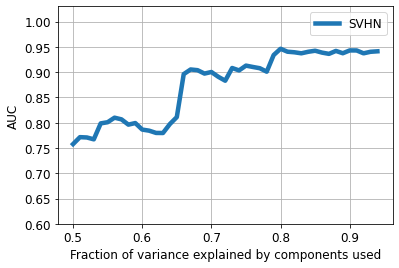

In [87]:
plt.figure()
plt.rcParams.update({'font.size': 12})

labels = ['SVHN']

ticks = np.arange(0.5, 0.95, 0.01)
aucs = []
for i in ticks:
    scoresIn = np.zeros(inTransformed[str(layer)].shape[0])
    scoresOut = np.zeros(inTransformed[str(layer)].shape[0])

    for layer in range(5):
        comps = np.where(np.cumsum(variances[str(layer)]) > i)[0][0]
        scoresIn += maha(trainTransformed[str(layer)][:, :comps], inTransformed[str(layer)][:, :comps])
        scoresOut += maha(trainTransformed[str(layer)][:, :comps], oodTransformed[str(layer)][:, :comps])

    aucs.append(auc(scoresIn, scoresOut))
plt.plot(ticks, aucs, label=labels[0], linewidth=4.5)

plt.ylim(0.6, 1.03)
plt.ylabel('AUC')
plt.xlabel('Fraction of variance explained by components used')
plt.legend()
plt.grid()
plt.show()
plt.close()

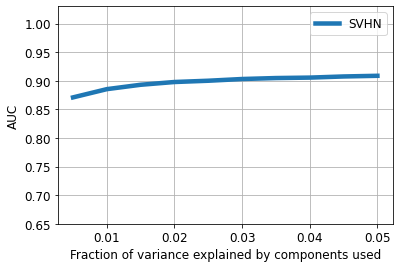

In [88]:
plt.figure()
labels = ['SVHN']

ticks = np.arange(0.95, 0.999, 0.005)
aucs = []
for i in ticks:
    scoresIn = np.zeros(inTransformed[str(layer)].shape[0])
    scoresOut = np.zeros(inTransformed[str(layer)].shape[0])

    for layer in range(5):
        comps = np.where(np.cumsum(variances[str(layer)]) > i)[0][0]

        scoresIn += maha(trainTransformed[str(layer)][:, comps:], inTransformed[str(layer)][:, comps:])
        scoresOut += maha(trainTransformed[str(layer)][:, comps:], oodTransformed[str(layer)][:, comps:])

    aucs.append(auc(scoresIn, scoresOut))
plt.plot(1 - ticks, aucs, label=labels[0], linewidth=4.5)
    
plt.ylim(0.65, 1.03)
plt.ylabel('AUC')
plt.xlabel('Fraction of variance explained by components used')
plt.legend()
plt.grid()
plt.show()
plt.close()